# Image filters

Original notebook by Weichao Qiu, modified by Donald Li, Chenxi Liu, Hongru Zhu, and Raj Magesh Gauthaman (rgautha1@jh.edu).

## Initialization

In [1]:
from __future__ import annotations
from collections.abc import Callable, Collection, Iterable
import itertools
import pickle

import numpy as np
from scipy.signal import convolve2d
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2gray

%matplotlib inline


def plot_image(image: np.ndarray, **kwargs) -> mpl.figure.Figure:
    """Utility function to plot an image.

    Args:
        image: a 2-D numpy array
    """
    fig = plt.figure()
    plt.axis('off')
    plt.imshow(image, cmap=plt.gray(), **kwargs)
    return fig


def surf(X, Y, Z, **kwargs):
    """Plot 3D data as surface, similar to surf(X,Y,Z) of http://www.mathworks.com/help/matlab/ref/surf.html"""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, **kwargs)
    return ax

## Utilities

### Create sinusoid stimuli

A sinusoid stimulus $I(\mathbf{x})$ is described by

$I(\mathbf{x}) = A \cos(\mathbf{\omega} \mathbf{x} + \rho) $

Here,

- $A$ is the amplitude
- $\mathbf{\omega}$ is the frequency
- $\rho$ is the phase


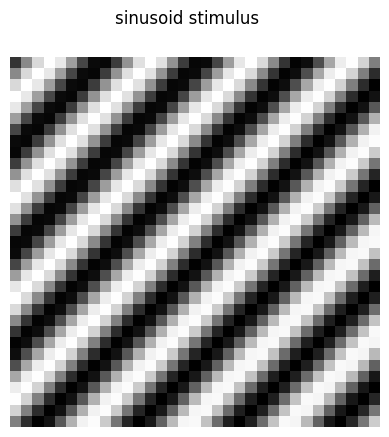

In [2]:
def create_sinusoid(
    size: tuple[int, int] = (32, 32),
    amplitude: float = 1,
    frequency: tuple[float, float] = (np.cos(np.pi / 4), np.sin(np.pi / 4)),
    phase: float = np.pi / 2
):
    """Creates a 2D sinusoid.

    Args:
        size: size of the generated stimulus, defaults to (32, 32)
        amplitude: amplitude of the sinusoid, defaults to 1
        frequency: spatial frequencies in the horizontal and vertical directions, defaults to (np.cos(np.pi / 4), np.sin(np.pi / 4))
        phase: phase, defaults to np.pi/2

    Returns:
        2D sinusoid
    """
    width, height = size
    radius = (width // 2, height // 2)
    [x, y] = np.meshgrid(range(-radius[0], radius[0] + 1), range(-radius[1], radius[1] + 1))

    return amplitude * np.cos(frequency[0] * x + frequency[1] * y + phase)


def plot_sinusoid():
    stimulus = create_sinusoid()
    fig = plot_image(stimulus)
    fig.suptitle("sinusoid stimulus")


plot_sinusoid()

### Create Gabor filters

A [general Gabor filter](https://en.wikipedia.org/wiki/Gabor_filter) can be defined as

$$ g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\exp\left(i\left(2\pi\frac{x'}{\lambda}+\psi\right)\right) $$

Here, we implement a Gabor filter that satisfies the neurophysiological constraints for simple cells:
   
$$ \psi (x; \omega, \theta, K) = \left[\frac{\omega^2}{ 4 \pi K^2} \exp  \{-(\omega^2/8K^2)[4(x\cdot(cos\theta, sin\theta))^2 + (x \cdot ( -sin \theta, cos \theta))^2]\} \right] \times \left[ \exp \{ iwx \cdot (cos\theta, sin\theta) \} exp(K^2/2) \right] $$

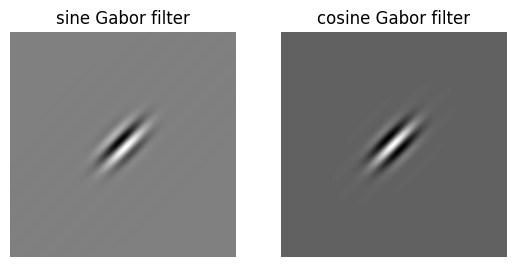

In [3]:
def create_gabor(
    size: tuple[int, int] = (256, 256),
    omega: float = 0.3,
    theta: float = np.pi / 4,
    k: float = np.pi,
    gabor_type: str = "cosine",
):
    """Creates a 2D Gabor filter that obeys V1 simple cell constraints.

    Args:
        size: size of the generated stimulus, defaults to (256, 256)
        omega: defaults to 0.3
        theta: defaults to np.pi/4
        k: defaults to np.pi
        gabor_type: whether to generate a sine Gabor or a cosine Gabor, defaults to "cosine"

    Returns:
        2D Gabor
    """
    width, height = size
    radius = (width // 2, height // 2)
    [x, y] = np.meshgrid(range(-radius[0], radius[0] + 1), range(-radius[1], radius[1] + 1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)

    gaussian = (omega**2 / (4 * np.pi * k**2)) * np.exp(- omega**2 / (8 * k**2) * ( 4 * x1**2 + y1**2))

    if gabor_type == "cosine":
        sinusoid = np.cos(omega * x1) * np.exp(k**2 / 2)
    elif gabor_type == "sine":
        sinusoid = np.sin(omega * x1) * np.exp(k**2 / 2)

    gabor = gaussian * sinusoid
    return gabor


def plot_gabor_filters():
    """Plot sine and cosine Gabor filters"""
    fig, axes = plt.subplots(nrows=1, ncols=2)
    for gabor_type, ax in zip(("sine", "cosine"), axes.flat):
        gabor = create_gabor(gabor_type=gabor_type)
        ax.axis("off")
        ax.imshow(gabor, cmap=plt.gray())
        ax.set_title(f"{gabor_type} Gabor filter")


plot_gabor_filters()

### Create Gabor filter banks

We create a set of Gabor filters that vary in

- the type of Gabor (sine or cosine)
- $\omega$
- $\theta$

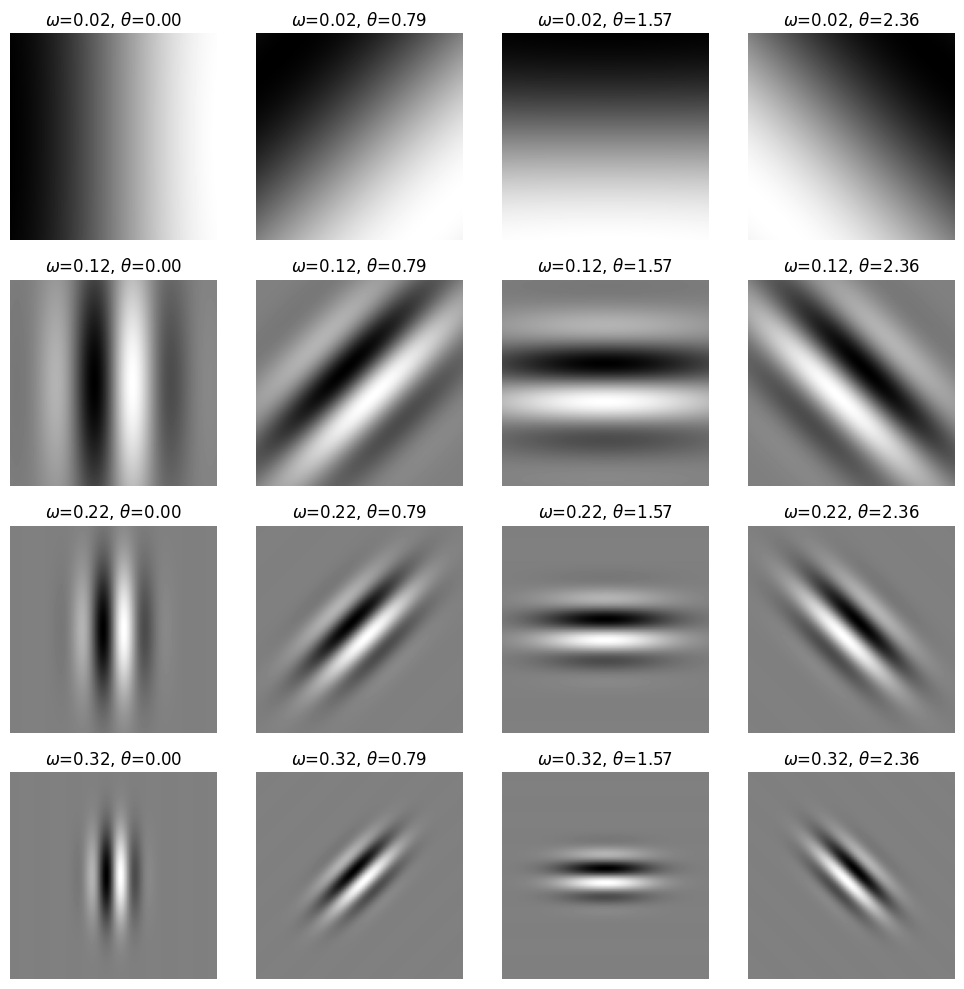

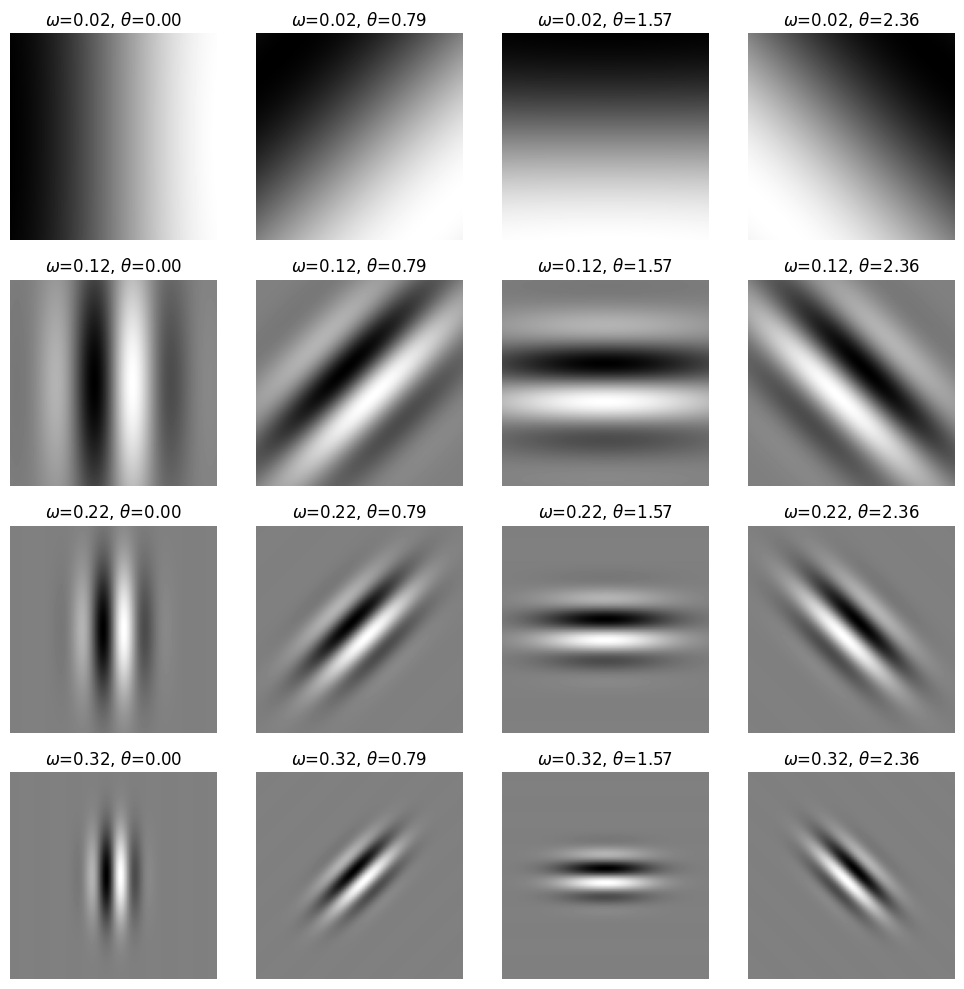

In [4]:
def create_gabor_filter_banks(
    omegas: Iterable[float] = np.arange(0.02, 0.42, 0.1),
    thetas: Iterable[float] = np.arange(0, np.pi, np.pi / 4)
) -> dict[str, list[np.ndarray]]:
    """Create Gabor filter banks of both sine and cosine Gabors at various values of omega and theta.

    Args:
        omegas: possible values of omega, defaults to np.arange(0.02, 0.42, 0.1)
        thetas: possible values of theta, defaults to np.arange(0, np.pi, np.pi / 4)

    Returns:
        Gabor filter banks
    """
    gabor_types = ("cosine", "sine")

    filter_banks = {gabor_type: [] for gabor_type in gabor_types}

    for omega in omegas:
        for theta in thetas:
            for gabor_type in gabor_types:
                filter_banks[gabor_type].append(
                    create_gabor(
                        size=(128, 128),
                        omega=omega,
                        theta=theta,
                        gabor_type=gabor_type
                    )
                )
    return filter_banks


def plot_filter_bank(
    filter_bank: Collection[np.ndarray],
    omegas: Iterable[float] = np.arange(0.02, 0.42, 0.1),
    thetas: Iterable[float] = np.arange(0, np.pi, np.pi / 4)
) -> mpl.figure.Figure:
    """Plot all 16 Gabor filters in each filter bank."""
    fig, axes = plt.subplots(nrows=len(thetas), ncols=len(omegas), figsize=(10, 10))
    for filter_bank, ax, (omega, theta) in zip(filter_banks["sine"], axes.flat, itertools.product(omegas, thetas)):
        ax.imshow(filter_bank)
        ax.axis("off")
        ax.set_title(f"$\omega$={omega:.2f}, $\\theta$={theta:.2f}")
    fig.tight_layout()
    return fig


filter_banks = create_gabor_filter_banks()

for gabor_type, filter_bank in filter_banks.items():
    plot_filter_bank(filter_bank=filter_bank)

### Demo: Gaussian, Laplacian of Gaussian

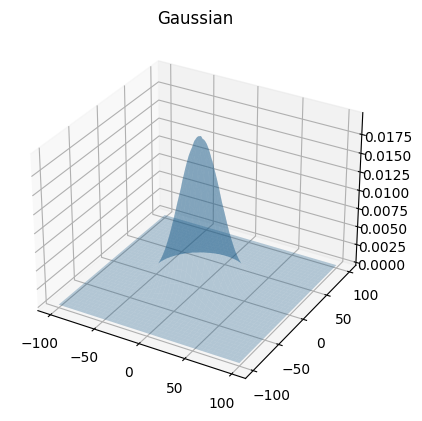

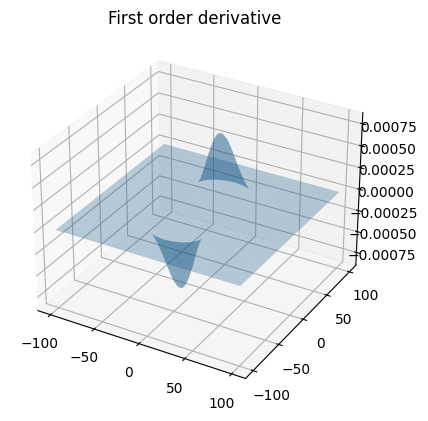

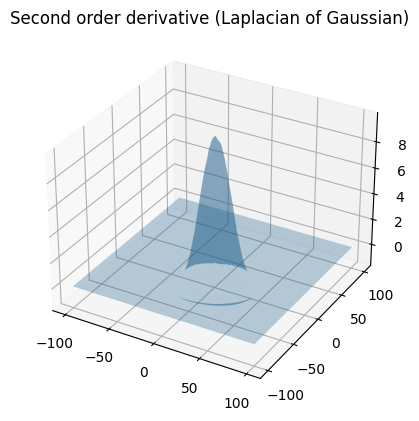

In [5]:
def plot_gaussian_and_derivatives():
    sigma = 20
    [X, Y] = np.meshgrid(np.arange(-100, 101), np.arange(-100, 101))
    Z = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(X**2 + Y**2)/(2 * sigma**2))

    dx = np.roll(Z, 1, axis=1) - Z
    dx2 = np.roll(dx, 1, axis=1) - dx

    dy = np.roll(Z, 1, axis=0) - Z
    dy2 = np.roll(dy, 1, axis=0) - dy

    LoG = -(dx2 + dy2)

    ax = surf(X, Y, Z, alpha=0.3)
    ax.set_title('Gaussian')

    ax = surf(X, Y, dx + dy, alpha=0.3)
    ax.set_title('First order derivative')

    ax = surf(X, Y, LoG, alpha=0.3)
    ax.set_title('Second order derivative (Laplacian of Gaussian)')


plot_gaussian_and_derivatives()

## Homework 1

### Question 4.1

- Apply Gabor filters to the zebra image. Note: You can use either the filters provided in the `filter_banks` dictionary (which are sufficient for this question) or create your own!
- Adjust the frequency and orientation of the Gabors to find the horizontal and vertical stripes.
- Plot the output. (3 points) Note: We only need to see images of filtered zebras, though images of the filters themselves (and their parameters) are welcome.
- Can you also find Gabors that respond to the legs? (3 points) Note: we mean the vertical legs themselves, not the thin horizontal stripes on the legs!

[See here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html) for examples of filters applied to texture processing!

(Image credits: "Zebra running Ngorongoro" by Muhammad Mahdi Karim (data/zebra.jpg))

In [6]:
def apply_gabor_to_zebra(gabor: np.ndarray = filter_banks["sine"][2]):
    zebra = rgb2gray(plt.imread("data/zebra.jpg"))
    fig = plot_image(zebra)
    fig.suptitle("original zebra")

    fig = plot_image(gabor)
    fig.suptitle("Gabor filter")

    gabor_filtered_zebra = convolve2d(zebra, gabor, mode="valid")  # Will take about one minute
    fig = plot_image(gabor_filtered_zebra)
    fig.suptitle("Gabor-filtered zebra")


apply_gabor_to_zebra(gabor=filter_banks["sine"][5])

FileNotFoundError: ignored

### Question 4.2: Quadrature pair, simple/complex cell

- Run the following example.
- Explain the results of the simple and complex cells when applying them to the stimuli. (4 points)
- Does the results match with your expectation?

In [ ]:
def simulate_quadrature_pair():
    theta = np.pi

    gabors = {
        gabor_type: create_gabor(size=(129, 129), omega=0.4, theta=np.pi, gabor_type=gabor_type)
        for gabor_type in ("sine", "cosine")
    }

    fig, axes = plt.subplots(nrows=1, ncols=2)
    for (gabor_type, gabor), ax in zip(gabors.items(), axes.flat):
        ax.imshow(gabor, vmin=-0.2, vmax=0.2)
        ax.set_title(f"{gabor_type} Gabor")
        ax.axis("off")


    omega = 0.1
    theta = np.pi / 4
    sinusoid = create_sinusoid(
        size=(256, 256),
        amplitude=1,
        frequency=(omega * np.sin(theta), omega * np.cos(theta)),
        phase=0,
    )
    fig = plot_image(sinusoid)
    fig.suptitle("stimuli")


    responses = {
        gabor_type: convolve2d(sinusoid, gabor, mode="valid")
        for gabor_type, gabor in gabors.items()
    }
    fig, axes = plt.subplots(nrows=1, ncols=3)
    axes[0].imshow(responses["sine"], vmin=0)
    axes[0].set_title("simple (sine Gabor)")
    axes[0].axis("off")
    axes[1].imshow(responses["cosine"], vmin=0)
    axes[1].set_title("simple (cosine Gabor)")
    axes[1].axis("off")
    axes[2].imshow(responses["sine"]**2 + responses["cosine"]**2, vmin=0)
    axes[2].set_title("complex")
    axes[2].axis("off")

    fig.suptitle("cell responses")
    fig.tight_layout()


simulate_quadrature_pair()

### Question 4.3: Find the parameters of an unknown Gabor filter

Find the tuning curve of an idealized neuron by measuring its response to different sinusoids. (3 points)

The neuron is a Gabor function so you need to find its preferred orientation, frequency, and phase. Use equations from [SimpleCellsVisualCortex - The Tuning of Gabor Filters](https://cs.jhu.edu/~ayuille/JHUcourses/ProbabilisticModelsOfVisualCognition2017/Lecture3SimpleCells/SimpleCellsVisualCortex.pdf) if you want.

In [ ]:
unknown_gabor = pickle.load(open('data/unknown_gabor.data', 'rb'), encoding='latin1')
fig = plot_image(unknown_gabor)
fig.suptitle("unknown Gabor")


def apply_sinusoid_to_image(
    image: np.ndarray,
    rho: float = 0,
    omega: float = 0.1,
    theta: float = np.pi / 3,
):
    # You can use sinusoids as stimuli. for example:
    sinusoid = create_sinusoid(
        size=image.shape,
        amplitude=1,
        frequency=(omega * np.cos(theta), omega * np.sin(theta)),
        phase=rho,
    )
    fig = plot_image(sinusoid)
    fig.suptitle("applied sinusoid")

    print(f"response = {(sinusoid * image).sum()}")


apply_sinusoid_to_image(unknown_gabor)

### Question 4.4: Find the parameters of an unknown Laplacian of Gaussian

Find the parameter $\sigma$ of a Laplacian of Gaussian filter by measuring its response to different sinusoids. (3 points)

Hint: The LoG is radially symmetric and centered, which means that you don't have to optimize over $\theta$ or $\rho$.

Note: To avoid any aliasing artifacts due to the small size of the image, please use small values of $\omega$ (e.g. between 0 and 1).

Use the equation(s) in [LinearModelsSimpleCells - The Response of a Center-Surround Cell to sinusoids](https://cs.jhu.edu/~ayuille/JHUcourses/ProbabilisticModelsOfVisualCognition2017/Lecture3SimpleCells/SimpleCellsRetina.pdf) if you want.

In [ ]:
unknown_LoG = pickle.load(open("data/unknown_LoG.data", "rb"), encoding="latin1")
fig = plot_image(unknown_LoG)
fig.suptitle("unknown Laplacian of Gaussian")
[X, Y] = np.meshgrid(np.arange(-100, 101), np.arange(-100, 101))
ax = surf(X, Y, unknown_LoG, alpha=0.3)
ax.set_title("unknown Laplacian of Gaussian")


apply_sinusoid_to_image(unknown_LoG)